In [ ]:
# Corrected Installation (no need for separate keras install)
!pip install numpy pillow tensorflow matplotlib kagglehub

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import kagglehub

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, Add, Lambda, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Verify TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [4]:
# Download dataset
path = kagglehub.dataset_download("jagan028/img-superres")
dataset_path = "/root/.cache/kagglehub/datasets/jagan028/img-superres/versions/1/AnalyticsArena_DataSet"

100%|██████████| 448M/448M [00:04<00:00, 113MB/s]

Extracting files...


In [5]:
# Based on your output, here are the correct paths:
lr_train_dir = os.path.join(dataset_path, "lowres", "LowReolution_3x_Train")  # Assuming this exists similarly to valid
hr_train_dir = os.path.join(dataset_path, "highres", "HighResolution_Train")
lr_valid_dir = os.path.join(dataset_path, "lowresvalid", "LowResolution_3x_Valid")
hr_valid_dir = os.path.join(dataset_path, "highresvalid", "HighResolution_Valid")

In [6]:
# Check if directories exist
print(f"Checking directories:")
print(f"LR train: {os.path.exists(lr_train_dir)}")
print(f"HR train: {os.path.exists(hr_train_dir)}")
print(f"LR valid: {os.path.exists(lr_valid_dir)}")
print(f"HR valid: {os.path.exists(hr_valid_dir)}")

Checking directories:
LR train: True
HR train: True
LR valid: True
HR valid: True


In [7]:
# Fix any incorrect paths
if not os.path.exists(lr_train_dir):
    # Checking parent directory
    lowres_dir = os.path.join(dataset_path, "lowres")
    if os.path.exists(lowres_dir):
        contents = os.listdir(lowres_dir)
        print(f"Contents of lowres directory: {contents}")

        # Try to find a directory with images
        for item in contents:
            item_path = os.path.join(lowres_dir, item)
            if os.path.isdir(item_path):
                if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(item_path)):
                    lr_train_dir = item_path
                    print(f"Found LR train directory: {lr_train_dir}")
                    break

In [8]:
# Create modified data generator that works with flat directories
def create_simple_generator(lr_dir, hr_dir, batch_size=32):
    # Check if directories exist
    if not os.path.exists(lr_dir):
        raise ValueError(f"LR directory not found: {lr_dir}")
    if not os.path.exists(hr_dir):
        raise ValueError(f"HR directory not found: {hr_dir}")

    # Get list of files
    lr_files = sorted([f for f in os.listdir(lr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    hr_files = sorted([f for f in os.listdir(hr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    print(f"Found {len(lr_files)} LR images and {len(hr_files)} HR images")

    # Handle mismatched file counts
    if len(lr_files) != len(hr_files):
        print(f"Warning: LR and HR image counts don't match. Using the minimum count.")
        min_count = min(len(lr_files), len(hr_files))
        lr_files = lr_files[:min_count]
        hr_files = hr_files[:min_count]

    # Create custom generator
    def generator():
        indices = np.arange(len(lr_files))
        while True:
            np.random.shuffle(indices)
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_size_actual = len(batch_indices)

                # Initialize batch arrays
                lr_batch = np.zeros((batch_size_actual, 170, 170, 3), dtype=np.float32)
                hr_batch = np.zeros((batch_size_actual, 510, 510, 3), dtype=np.float32)

                for j, idx in enumerate(batch_indices):
                    try:
                        # Load and preprocess LR image
                        lr_img = Image.open(os.path.join(lr_dir, lr_files[idx]))
                        lr_img = lr_img.resize((170, 170)).convert('RGB')
                        lr_batch[j] = np.array(lr_img) / 255.0

                        # Load and preprocess HR image
                        hr_img = Image.open(os.path.join(hr_dir, hr_files[idx]))
                        hr_img = hr_img.resize((510, 510)).convert('RGB')
                        hr_batch[j] = np.array(hr_img) / 255.0
                    except Exception as e:
                        print(f"Error processing image {lr_files[idx]} or {hr_files[idx]}: {e}")
                        # Fill with zeros if image loading fails

                yield lr_batch, hr_batch

    return generator(), max(1, len(lr_files) // batch_size)

In [9]:
# Create generators and get steps
print("\nCreating training data generator...")
train_gen, train_steps = create_simple_generator(lr_train_dir, hr_train_dir, batch_size=32)



Creating training data generator...
Found 3500 LR images and 3500 HR images


In [10]:
print("\nCreating validation data generator...")
val_gen, val_steps = create_simple_generator(lr_valid_dir, hr_valid_dir, batch_size=32)


Creating validation data generator...
Found 1000 LR images and 1000 HR images


In [11]:
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

Training steps per epoch: 109
Validation steps per epoch: 31


In [12]:
# Define PSNR metric (Peak Signal-to-Noise Ratio)
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

Improvements

In [13]:
from tensorflow.keras.layers import BatchNormalization, PReLU

def ResBlock(input_layer, filters):
    x = Conv2D(filters, 3, padding='same')(input_layer)
    x = PReLU()(x)  # Replaces ReLU
    x = BatchNormalization()(x)  # Normalizes activations

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)  # Stabilizes training

    return Add()([input_layer, x])


In [14]:
def InterConnected(input_shape):
    inputs = Input(input_shape)

    # Initial convolution
    x = Conv2D(32, 3, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(8): #improvements by us 2->8
        x = ResBlock(x, 32)

    # Upsampling block
    x = Conv2D(32 * (3**2), 3, padding='same')(x)  # 3x upscale factor
    x = Lambda(lambda x: tf.nn.depth_to_space(x, 3))(x)

    # Final convolution
    outputs = Conv2D(3, 1, activation='sigmoid')(x)  # Sigmoid for [0,1] range

    return Model(inputs, outputs)

In [15]:
# Create model
model = InterConnected((170, 170, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 170, 170, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 170, 170, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 170, 170, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu (PReLU)           │ (None, 170, 170, 32)   │        924,800 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 170, 170, 32)   │            128 │ p_re_lu[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 170, 170, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 170, 170, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 170, 170, 32)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 170, 170, 32)   │          9,248 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_1 (PReLU)         │ (None, 170, 170, 32)   │        924,800 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 170, 170, 32)   │            128 │ p_re_lu_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 170, 170, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 170, 170, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 170, 170, 32)   │              0 │ add[0][0],             │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 170, 170, 32)   │          9,248 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_2 (PReLU)         │ (None, 170, 170, 32)   │        924,800 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,632,643 (29.12 MB)

 Trainable params: 7,631,619 (29.11 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [16]:
# Check GPU availability
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [17]:
# Compile and train the model
with tf.device('/GPU:0'):  # Use GPU 0
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',
                  metrics=[psnr])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[early_stop]
    )

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 121s 804ms/step - loss: 0.0511 - psnr: 14.4496 - val_loss: 0.0555 - val_psnr: 12.7547
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 98s 798ms/step - loss: 0.0068 - psnr: 21.9762 - val_loss: 0.0422 - val_psnr: 13.9662
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.0044 - psnr: 23.8683 - val_loss: 0.0212 - val_psnr: 16.9372
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - loss: 0.0035 - psnr: 24.8877 - val_loss: 0.0108 - val_psnr: 19.7942
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - loss: 0.0029 - psnr: 25.7343 - val_loss: 0.0041 - val_psnr: 24.0038
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 87s 796ms/step - loss: 0.0026 - psnr: 26.1832 - val_loss: 0.0024 - val_psnr: 26.5576
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.0026 - psnr: 26.2522 - val_loss: 0.0021 - val_psnr: 27.2184
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 86s 792ms/step - loss: 0.0025 - psnr: 26.4951 - val_loss: 0.0019 - val_psnr: 27.5507
Epoch 9

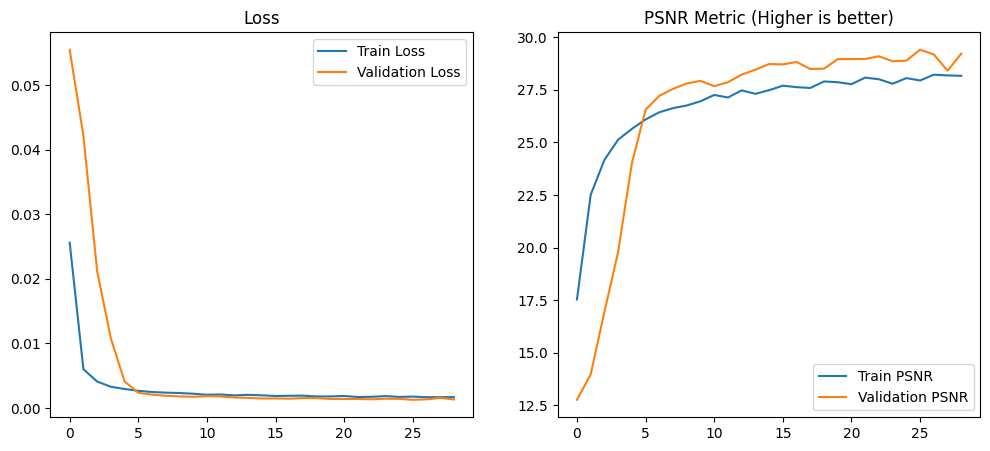

In [18]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['psnr'], label='Train PSNR')
plt.plot(history.history['val_psnr'], label='Validation PSNR')
plt.legend()
plt.title('PSNR Metric (Higher is better)')
plt.show()

In [19]:
model.save('super_res_model.keras')


In [20]:
# Function to find a valid test image in LR dir and try to match with HR dir
def find_test_image_with_hr(lr_dir, hr_dir):
    if not os.path.exists(lr_dir) or not os.path.exists(hr_dir):
        return None, None

    # Get list of available files
    lr_files = [f for f in os.listdir(lr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    hr_files = [f for f in os.listdir(hr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not lr_files:
        return None, None

    # Try a few approaches to match LR and HR files

    # Approach 1: Try to find exact match
    for lr_file in lr_files:
        if lr_file in hr_files:
            return os.path.join(lr_dir, lr_file), os.path.join(hr_dir, lr_file)

    # Approach 2: Try to find match by number in filename (common in datasets)
    for lr_file in lr_files:
        # Extract numbers from filename
        lr_nums = ''.join(filter(str.isdigit, lr_file))

        if lr_nums:
            for hr_file in hr_files:
                hr_nums = ''.join(filter(str.isdigit, hr_file))
                if lr_nums == hr_nums:
                    return os.path.join(lr_dir, lr_file), os.path.join(hr_dir, hr_file)

    # Approach 3: If no match found, simply use the first file and print a warning
    print("Warning: Could not find matching filenames between LR and HR directories.")
    print("Using first available LR and HR images for visualization.")
    print("The HR image may not correspond to the LR image.")

    return os.path.join(lr_dir, lr_files[0]), os.path.join(hr_dir, hr_files[0])

In [21]:
# Function to prepare and predict a super-resolved image
def predict_image(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure image is RGB
    lr_img = np.array(img.resize((170, 170))) / 255.0
    pred = model.predict(np.expand_dims(lr_img, axis=0))[0]
    return (np.clip(pred, 0, 1) * 255).astype(np.uint8)

Searching for test images...
Using test images: 
LR: /root/.cache/kagglehub/datasets/jagan028/img-superres/versions/1/AnalyticsArena_DataSet/lowresvalid/LowResolution_3x_Valid/Img_down4275.jpg
HR: /root/.cache/kagglehub/datasets/jagan028/img-superres/versions/1/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid/Img4275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


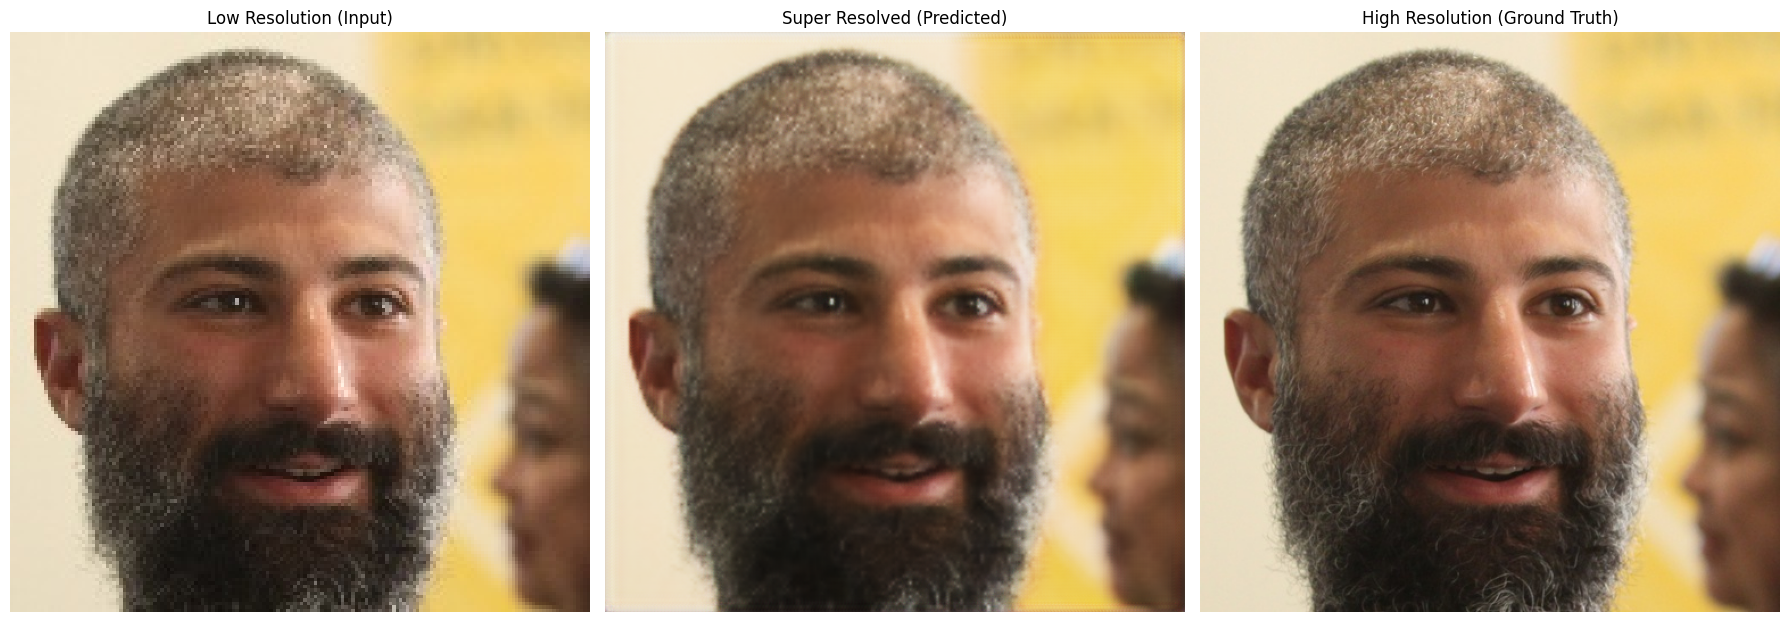

PSNR between predicted and ground truth: 31.57 dB
Note: If the LR and HR images don't actually correspond, this PSNR value is not meaningful.

Image Information:
LR image shape: (170, 170, 3)
Predicted SR image shape: (510, 510, 3)
HR image shape: (510, 510, 3)


In [22]:
# Find test images
print("Searching for test images...")
test_lr_path, test_hr_path = find_test_image_with_hr(lr_valid_dir, hr_valid_dir)
if test_lr_path is None or test_hr_path is None:
    print("Could not find test images in validation set. Searching in training directories instead.")
    test_lr_path, test_hr_path = find_test_image_with_hr(lr_train_dir, hr_train_dir)

if test_lr_path and test_hr_path:
    print(f"Using test images: \nLR: {test_lr_path}\nHR: {test_hr_path}")

    try:
        # Predict
        predicted_hr = predict_image(model, test_lr_path)

        # Display all three images
        plt.figure(figsize=(18, 7))

        # Display low resolution image
        plt.subplot(1, 3, 1)
        plt.title("Low Resolution (Input)")
        lr_img = Image.open(test_lr_path).resize((170, 170))
        plt.imshow(lr_img)
        plt.axis('off')

        # Display super-resolved image
        plt.subplot(1, 3, 2)
        plt.title("Super Resolved (Predicted)")
        plt.imshow(predicted_hr)
        plt.axis('off')

        # Display original high resolution image
        plt.subplot(1, 3, 3)
        plt.title("High Resolution (Ground Truth)")
        hr_img = Image.open(test_hr_path).resize((510, 510))
        plt.imshow(hr_img)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Try to calculate PSNR (only if images actually correspond)
        try:
            ground_truth = np.array(hr_img) / 255.0
            predicted_normalized = predicted_hr / 255.0

            psnr_value = tf.image.psnr(
                tf.convert_to_tensor(ground_truth, dtype=tf.float32),
                tf.convert_to_tensor(predicted_normalized, dtype=tf.float32),
                max_val=1.0
            )

            print(f"PSNR between predicted and ground truth: {psnr_value.numpy():.2f} dB")
            print("Note: If the LR and HR images don't actually correspond, this PSNR value is not meaningful.")
        except Exception as e:
            print(f"Could not calculate PSNR: {e}")

        # Print additional information about the images
        print(f"\nImage Information:")
        print(f"LR image shape: {np.array(lr_img).shape}")
        print(f"Predicted SR image shape: {predicted_hr.shape}")
        print(f"HR image shape: {np.array(hr_img).shape}")

    except Exception as e:
        print(f"Error during prediction or visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No test images found in the dataset.")